# Part 1: Feature Extraction
## Permutation Entropy
### 1) Load EEG data

In [4]:
import numpy as np

# Load Patient 14 data from text file
eeg_data = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 EEG.txt')

### 2) Band filter

In [5]:
from scipy.signal import butter, filtfilt

# Define band filter
def band_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Sampling frequency = 128 Hz
fs = 128

# Apply filters for each band
delta_band = band_filter(eeg_data, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band = band_filter(eeg_data, 4, 8, fs) # 4 to 8 Hz
alpha_band = band_filter(eeg_data, 8, 13, fs) # 8 to 13 Hz
beta_band = band_filter(eeg_data, 13, 30, fs) # 13 to 30 Hz
gamma_band = band_filter(eeg_data, 30, 63, fs) # 30 to 63 Hz (within Nyquist range)

### 3) Separate beta band into overlapping windows

In [6]:
# Create overlapping 56 s windows of beta band, advancing by 1 s
def moving_window(data, window_size, step_size, fs):
    num_points = len(data)
    window_length = window_size * fs # Length of window in data points
    step_length = step_size * fs # Length of step in data points
    windows = []
    for start in range(0, num_points - window_length + 1, step_length):
        windows.append(data[start:start + window_length])
    return np.array(windows)

window_size = 56 # Length of window in seconds
step_size = 1 # Length of step in seconds
beta_windows = moving_window(beta_band, window_size, step_size, fs)

In [19]:
print(beta_windows.shape) ## Check window count and number of data points in each

(3001, 7168)


### 4) Calculate permutation entropy of each window

In [7]:
from pyentrp import entropy as ent

pe_values = []
for window in beta_windows:
    pe = ent.permutation_entropy(window, order=3, delay=1)
    pe_values.append(pe)

pe_values = np.array(pe_values)

### 5) Plot permutation entropy values

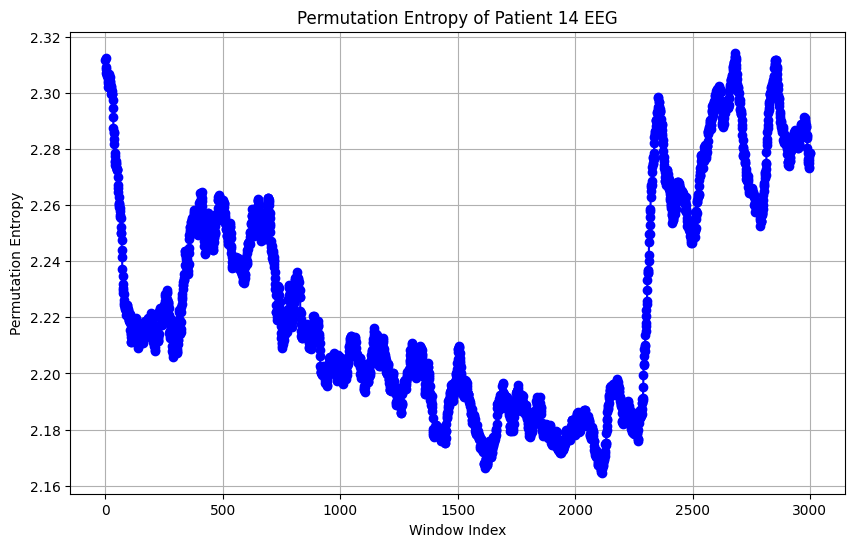

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pe_values, marker='o', linestyle='-', color='b')
plt.title('Permutation Entropy of Patient 14 EEG')
plt.xlabel('Window Index')
plt.ylabel('Permutation Entropy')
plt.grid(True)
plt.show()

## 6) Comparison with Bispectral Index (BIS)

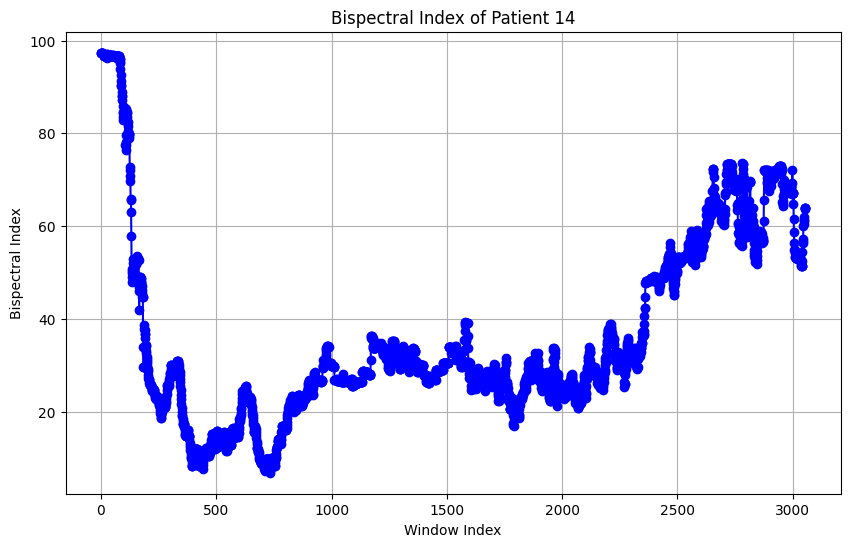

In [9]:
patient14_bis = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 BIS.txt')
plt.figure(figsize=(10, 6))
plt.plot(patient14_bis, marker='o', linestyle='-', color='b')
plt.title('Bispectral Index of Patient 14')
plt.xlabel('Window Index')
plt.ylabel('Bispectral Index')
plt.grid(True)
plt.show()

## Mobility
### 1) Calculate mobility for Patient 14

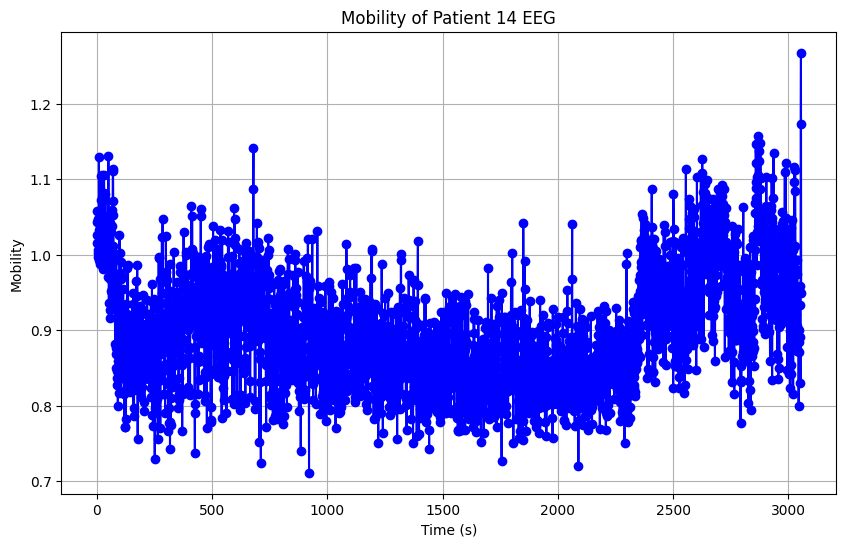

In [23]:
# Split beta band into 1-second windows
mobility_windows = moving_window(beta_band, 1, 1, fs)

# Calculate mobility of given dataset
def calculate_mobility(signal):
    first_derivative = np.diff(signal, 1)
    variance = np.var(signal)
    variance_first_derivative = np.var(first_derivative)
    mobility = np.sqrt(variance_first_derivative / variance)
    return mobility

# Calculate mobility for each second
mobility_values = []
for window in mobility_windows:
    m = calculate_mobility(window)
    mobility_values.append(m)

mobility_values = np.array(mobility_values)

# Plot mobility
plt.figure(figsize=(10, 6))
plt.plot(mobility_values, marker='o', linestyle='-', color='b')
plt.title('Mobility of Patient 14 EEG')
plt.xlabel('Time (s)')
plt.ylabel('Mobility')
plt.grid(True)
plt.show()

**Discussion:**
The above figure graphs the mobility of each second of Patient 14's EEG. The variation is generally consistent across the signal, but there is noticeably lower variation during the first ~100 seconds and heightened variation towards the end. The period of low variation roughly coincides with the consistent drop in permutation entropy and BIS, which must be due to anesthetic being administered during this time.

### 2) Calculate mobility for Patient 12

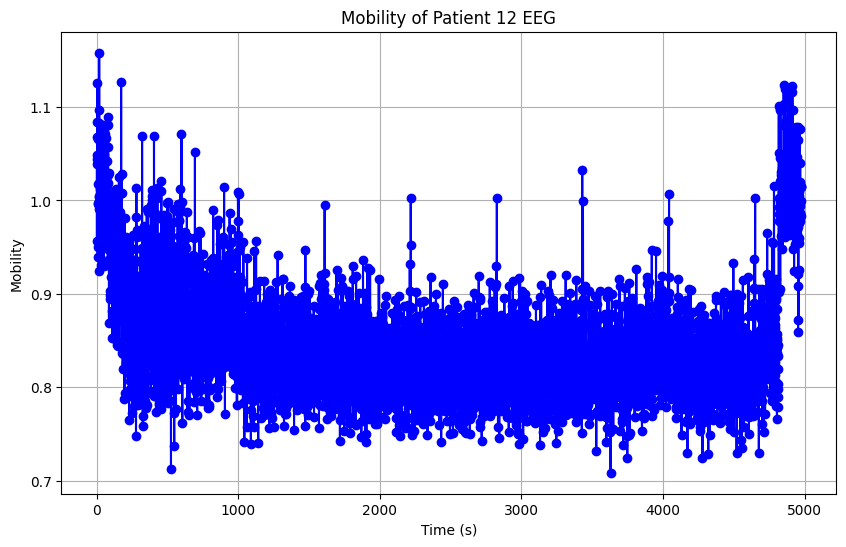

In [22]:
# Load Patient 12 data
eeg_data_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 EEG data.txt')
bis_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 BIS.txt')

# Apply filters for each band for Patient 12
delta_band_patient12 = band_filter(eeg_data_patient12, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band_patient12 = band_filter(eeg_data_patient12, 4, 8, fs) # 4 to 8 Hz
alpha_band_patient12 = band_filter(eeg_data_patient12, 8, 13, fs) # 8 to 13 Hz
beta_band_patient12 = band_filter(eeg_data_patient12, 13, 30, fs) # 13 to 30 Hz
gamma_band_patient12 = band_filter(eeg_data_patient12, 30, 63, fs) # 30 to 63 Hz (within Nyquist range)

# Split beta band into 1-second windows
mobility_windows_patient12 = moving_window(beta_band_patient12, 1, 1, fs)

# Calculate mobility for each second
mobility_values_patient12 = []
for window in mobility_windows_patient12:
    m = calculate_mobility(window)
    mobility_values_patient12.append(m)

mobility_values_patient12 = np.array(mobility_values_patient12)

# Plot mobility
plt.figure(figsize=(10, 6))
plt.plot(mobility_values_patient12, marker='o', linestyle='-', color='b')
plt.title('Mobility of Patient 12 EEG')
plt.xlabel('Time (s)')
plt.ylabel('Mobility')
plt.grid(True)
plt.show()

**Discussion:** Patient 12's EEG oscillates between slightly lower mobility values throughout the bulk of the signal when compared to Patient 14 (mostly 0.9 or lower), with some patterns in its spikes during this period. Like Patient 14, mobility decreases during the first 50-100 seconds, and increases towards the end, possibly indicating that mobility is higher during transitions between different anesthetic states.

# Part Two: Modelling
## Linear Regression
### 1) Create and train linear regression model

Pearson Correlation Coefficient: 0.6184491485666381
The equation of the regression line is: y = 287.03632706217047x + -603.4144970953876


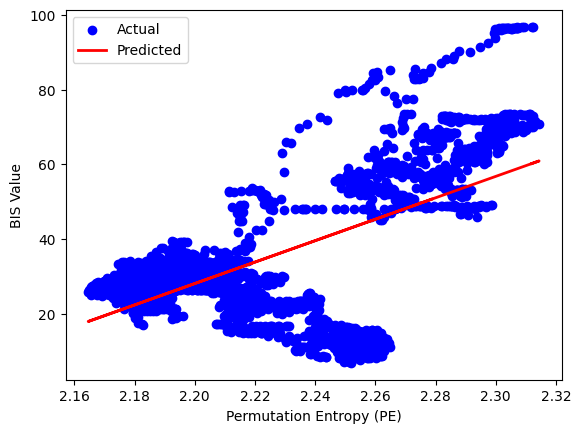

In [25]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load BIS data of Patient 14
patient14_bis = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 BIS.txt')

pe_df = pd.DataFrame(pe_values, columns=['PE']) # Convert PE numpy array to pandas DataFrame

# Align BIS and PE values by disregarding the first 55 BIS values, as each PE value will represent the end of the window
bis_aligned = patient14_bis[55:55+len(pe_df)]

# Prepare data
bis_series = pd.Series(bis_aligned, name='BIS')
X = pe_df[['PE']]
y = bis_series

# Calculate Pearson Correlation Coefficient
correlation = np.corrcoef(pe_values, bis_series)[0, 1]
print(f'Pearson Correlation Coefficient: {correlation}')

# Create and train model
model = LinearRegression()
model.fit(X, y)

# Get coefficient and intercept of regression line
k = model.coef_[0]
b = model.intercept_
print(f'The equation of the regression line is: y = {k}x + {b}')

# Make predictions
y_pred = model.predict(X)

# Plot regression line
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Permutation Entropy (PE)')
plt.ylabel('BIS Value')
plt.legend()
plt.show()

### Fitness of model - Patient 14 (training data)
The linear regression model created above is a poor predictor of the relationship between permutation entropy and BIS value for Patient 14. It can be seen from the scatterplot that the data points exhibit clustering and various other oddities in distribution; therefore, the data is not linearly separable. A Pearson Correlation Coefficient of only 0 indicates that the regression line does not closely fit the data. However, the model does display a general negative correlation between the two variables, suggesting that higher PE values typically indicate a deeper level of anesthesia (lower BIS values).

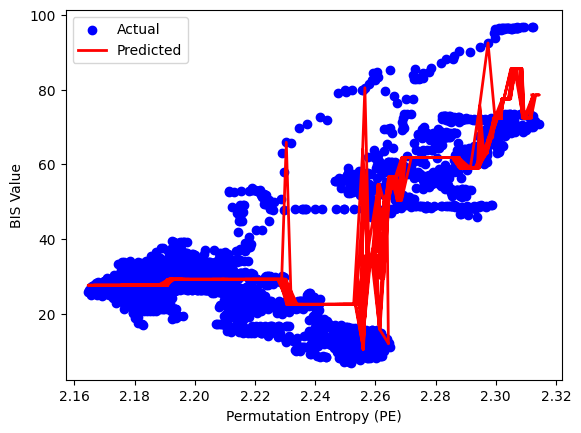

Pearson Correlation Coefficient: 0.8290847192794116


In [87]:
# Using a Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(max_depth=5)
tree_model.fit(X, y)
y_tree_pred = tree_model.predict(X)

plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_tree_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Permutation Entropy (PE)')
plt.ylabel('BIS Value')
plt.legend()
plt.show()

correlation_poly = np.corrcoef(y, y_tree_pred)[0, 1]
print(f'Pearson Correlation Coefficient: {correlation_poly}')

### 2) Test linear model using Patient 12 data

Pearson Correlation Coefficient: 0.27700896065791814


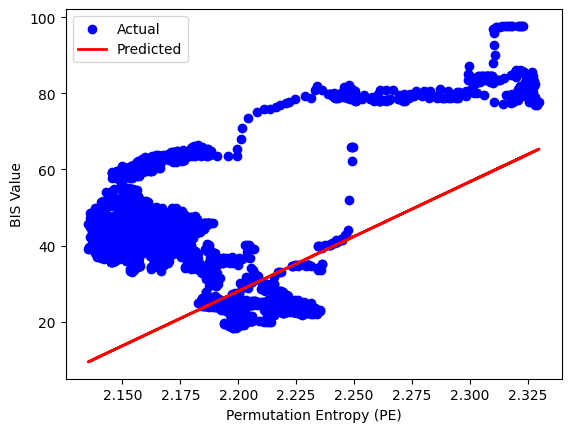

In [26]:
# Create moving window for Patient 12
beta_windows_patient12 = moving_window(beta_band_patient12, window_size, step_size, fs)

# Calculate PE values for Patient 12
pe_values_patient12 = []
for window in beta_windows_patient12:
    pe12 = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_patient12.append(pe12)

pe_values_patient12 = np.array(pe_values_patient12)

# Prepare trained model with test data
pe_df_patient12 = pd.DataFrame(pe_values_patient12, columns=['PE'])
X_patient12 = pe_df_patient12[['PE']]

# Make predictions
y_pred_patient12 = model.predict(X_patient12)

# Align BIS and PE values by disregarding the first 55 BIS values, as each PE value will represent the end of the window
bis_aligned_patient12 = bis_patient12[55:55+len(pe_df_patient12)]

# Calculate Pearson Correlation Coefficient
correlation_patient12 = np.corrcoef(bis_aligned_patient12, y_pred_patient12)[0, 1]
print(f'Pearson Correlation Coefficient: {correlation_patient12}')

# Plot regression line for Patient 12
plt.scatter(X_patient12['PE'], bis_aligned_patient12, color='blue', label='Actual')
plt.plot(X_patient12['PE'], y_pred_patient12, color='red', linewidth=2, label='Predicted')
plt.xlabel('Permutation Entropy (PE)')
plt.ylabel('BIS Value')
plt.legend()
plt.show()

### Fitness of model - Patient 12 (Testing Data)
The linear regression model trained on Patient 14's data is a very poor predictor of the relationship between permutation entropy and BIS for Patient 12, with a Pearson Correlation Coefficient of only 0.28. The regression line fails to capture Patient 12's data clusters during deeper states of anesthesia and falls consistently below the BIS values in lighter states.